<a href="https://colab.research.google.com/github/annaiandresen/whats-ur-l1/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Bidirectional LSTM using Tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd

usingGpu = True if len(tf.config.list_physical_devices('GPU')) > 0 else False
usingGpu

True

In [5]:
# Load datasets
df = pd.read_csv("/content/gdrive/MyDrive/model/cleaned_dataset.csv", usecols=['text', 'label']) 
df = df.dropna()
df

,text,label
0,In France we have Le petit journal '' which I ...,0
1,I'm sure now that there are other shows taken ...,0
2,But otherwise we've had fake comedy news like,0
3,A mélodie is a French art song.,0
4,It is the French equivalent of the German lied.,0
...,...,...
1499995,"I'll talk again about the Komi republic, as I ...",2
1499996,"The Komi languages are first order citizens, i...",2
1499997,Russia is too big and diverse for it to NOT be...,2
1499998,"EDIT: Also, Kiev has always spoken the dominan...",2


In [6]:
# Shuffle and split into 60 / 20 / 20
train, validate, test = np.split(df.sample(frac=1), [int(.6 * len(df)), int(.8 * len(df))])

x_train, y_train = train['text'].values, train['label'].values
x_test, y_test = test['text'].values, test['label'].values
x_val, y_val = validate['text'].values, validate['label'].values

# For faster training!
x_train_tf = tf.convert_to_tensor(x_train) if usingGpu else x_train
x_test_tf = tf.convert_to_tensor(x_test) if usingGpu else x_test
x_val_tf = tf.convert_to_tensor(x_val) if usingGpu else x_val

x_train_tf

<tf.Tensor: shape=(899367,), dtype=string, numpy=
array([b'Matthews.',
       b'He is riding the conspiracy wave into loonie town.',
       b'Lesson still applies here though.', ...,
       b'Mr Markov is pretty desperate to uphold his little worldview in face of reality.',
       b'I do agree that short term stay will most probably stay possible and visa-free, but there is no guarantee that work visas would be automatically available, which was the point of / u/iinavpov.',
       b'It makes so much sense, says a little voice deep in my mind.'],
      dtype=object)>

In [7]:
import matplotlib.pyplot as plt

# Plot history graphs to check for overfitting
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

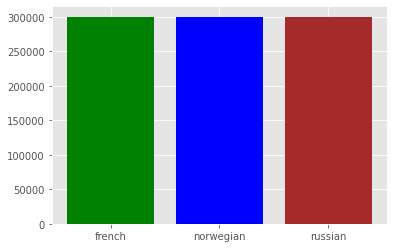

In [8]:
# Check that we have an equal number of labels for each language in our train set
dd = pd.Series(y_train).value_counts()
colors = ['green', 'blue','brown']
plt.style.use('ggplot')  # Use ggplot styles
plt.bar(['french', 'norwegian', 'russian'], dd.values, color=colors)
plt.show()

In [9]:
# Text encoder
encoder = keras.layers.TextVectorization()
encoder.adapt(x_train_tf)
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'a', 'and', 'of', 'in', 'is', 'i',
       'that', 'it', 'you', 'for', 'not', 'are', 'but', 'with', 'on',
       'have'], dtype='<U314')

In [10]:
encoded_example = encoder("This is an example").numpy()
encoded_example

array([ 24,   8,  44, 277])

In [11]:
# Bidirectional LSTM Model
model = tf.keras.Sequential([
    encoder,
    keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    keras.layers.Dropout(0.1),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    keras.layers.Dropout(0.1),
    keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(3)  # for 3 labels
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.0003),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          11641280  
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              9

In [12]:
# Hyperparams if GPU is available
if usingGpu:
    # GPU
    bs = 12  # Number of images used in each iteration
    epochs = 2  # Number of passes through entire dataset
    print("Using GPU")
    
# Hyperparams for CPU training
else:
    # CPU
    bs = 6
    epochs = 1
    print("Using CPU")

Using GPU


In [13]:
# Train train train!
history = model.fit(
    x=x_train_tf,
    y=y_train,
    batch_size=bs,
    epochs=epochs,
    verbose=1,
    validation_data=(x_val_tf, y_val),
    validation_steps=len(x_val_tf) // bs)

Epoch 1/2
74948/74948 [==============================] - 3702s 49ms/step - loss: 0.8396 - accuracy: 0.5973 - val_loss: 0.8018 - val_accuracy: 0.6200
Epoch 2/2
74948/74948 [==============================] - 3663s 49ms/step - loss: 0.7712 - accuracy: 0.6427 - val_loss: 0.7862 - val_accuracy: 0.6300


In [ ]:
# Save model
model.save(
    "/content/gdrive/MyDrive/model/lstm",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model/lstm/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/model/lstm/assets


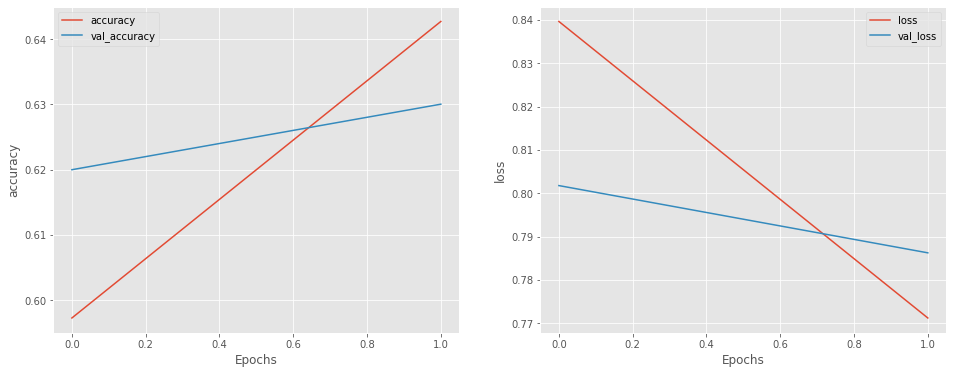

In [14]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [15]:
test_loss, test_acc = model.evaluate(x_test_tf, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

9369/9369 [==============================] - 162s 17ms/step - loss: 0.7859 - accuracy: 0.6310
Test Loss: 0.7859215140342712
Test Accuracy: 0.630973756313324


In [16]:
# Prepare data for scikit-learn confusion matrix and classification report
y_pred = model.predict(x_test_tf)

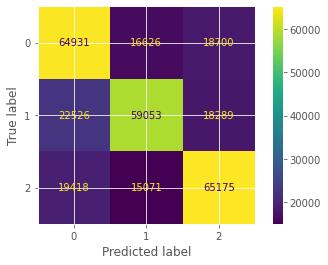

In [17]:
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred=np.argmax(y_pred, axis=1), y_true=y_test, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1", "2"])
disp.plot()
plt.show()

In [18]:
from sklearn.metrics import classification_report
report = classification_report(y_pred=np.argmax(y_pred, axis=1), y_true=y_test, target_names=["0", "1", "2"], output_dict=True)
df_report = pd.DataFrame(report)
df_report

,0,1,2,accuracy,macro avg,weighted avg
precision,0.607542,0.650722,0.637945,0.630974,0.632069,0.632034
recall,0.647646,0.591311,0.653947,0.630974,0.630968,0.630974
f1-score,0.626953,0.619595,0.645847,0.630974,0.630798,0.630783
support,100257.000000,99868.000000,99664.000000,0.630974,299789.000000,299789.000000
